# DeepGaze IIE pour le calcul de saillance en situation d'image non réaliste

## Principe d'utilisation et source

Ce notebook est construit à partir du notebook déposé sur le repo GitHub DeepGaze, et disponible à l'adresse : https://github.com/matthias-k/DeepGaze/tree/main

L'objectif est de tester la robustesse et la vitesse d'exécution du modèle générique pré-entraîné sur des images de type photoréaliste, face à des images simplifiées de types "Cartoon". 

(rajouter source de données de test et lien du papier)

## Méthode de comparaison des résultats avec le modèle KSDG20 employé actuellement

Chaque modèle est tout d'abord comparé avec l'observation expérimentale du regard utilisateur confronté à la scène dont les frames sont utilisées ici pour l'évaluation. On observe dansd un premier temps si une intersection existe entre la saillance calculée d'une frame et le regard de l'utilisateur sur une plage de 1 seconde (fréquence de rafraichissement du modèle vis à vis du mouvement de la vidéo). Si cette intersection est non vide, alors le modèle a deviné juste (précision = 1), sinon il a faux (précision = 0). Cette méthode de comparaison sera revue plus tard, et ajustée en réponse à des comportements détaillés dans la suite du notebook.

## Implémentation

Imports des librairies et fonctions nécessaires

In [2]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
from PIL import Image

from matplotlib import cm

import deepgaze_pytorch
import matplotlib.pyplot as plt
from pysaliency.plotting import visualize_distribution

#DEVICE = 'cuda'
DEVICE='cpu'
# you can use DeepGazeI or DeepGazeIIE
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)
centerbias_template = np.load('centerbias_mit1003.npy')

from matplotlib import image


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\dunea/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\dunea/.cache\torch\hub\pytorch_vision_v0.6.0


Obtention de tous les urls des images à tester

In [30]:
## Urls des images à tester pour E1

url_base = "C:/Users/dunea/Documents/Projet Julia/Human-Attention/data/processed_data/active/E1/"
urls1 = []
for i in range (0,500):
    if i < 10:
        U = url_base + "000" + str(i)
    elif i < 100:
        U = url_base + "00" + str(i)
    else:
        U = url_base + "0" + str(i)
    screen = U + "/screen.png"
    saliency = U + "/saliency_with_dg.png"
    saliency_heatmap = U + "/saliency_heatmap_with_dg.png"

    try :
        img = Image.open(screen).convert('RGB')
        urls1.append([screen, saliency, saliency_heatmap])
    except FileNotFoundError:
        continue

## Urls des images à tester pour E10
    
url_base = "C:/Users/dunea/Documents/Projet Julia/Human-Attention/data/processed_data/active/E10/"
urls2 = []
for i in range (0,500):
    if i < 10:
        U = url_base + "000" + str(i)
    elif i < 100:
        U = url_base + "00" + str(i)
    else:
        U = url_base + "0" + str(i)
    screen = U + "/screen.png"
    saliency = U + "/saliency_with_dg.png"
    saliency_heatmap = U + "/saliency_heatmap_with_dg.png"

    try :
        img = Image.open(screen).convert('RGB')
        urls2.append([screen, saliency, saliency_heatmap])
    except FileNotFoundError:
        continue

## Urls des images à tester pour E11
    
url_base = "C:/Users/dunea/Documents/Projet Julia/Human-Attention/data/processed_data/active/E11/"
urls3 = []
for i in range (0,500):
    if i < 10:
        U = url_base + "000" + str(i)
    elif i < 100:
        U = url_base + "00" + str(i)
    else:
        U = url_base + "0" + str(i)
    screen = U + "/screen.png"
    saliency = U + "/saliency_with_dg.png"
    saliency_heatmap = U + "/saliency_heatmap_with_dg.png"

    try :
        img = Image.open(screen).convert('RGB')
        urls3.append([screen, saliency, saliency_heatmap])
    except FileNotFoundError:
        continue

In [32]:
#urls1
#urls2
#urls3

Test préliminaire sur 1 image, premier aperçu des résultats et vérification de la cohérence de la méthode. On constate dans un premier temps des incohérences, qui sont résolues en redimensionnant les images à la taille des photos utilisées pour l'entraînement du modèle (1024 de largeur, comme recommandé dans la documentation).

Les résultats sont corrects, l'exécution semble un peut lente pour l'exécution en temps réel et rafraîchissement toutes les secondes (ici 4.7sec d'exécution). Une explication raisonnable de ces performances est évidemment l'emploi ici du cpu, et non pas de la méthode CUDA exploitant les capacités du gpu.

Des tests subsidiaires sur une autre machine sont nécessaires.

Enfin, on teste l'enregistrement correct des images obtenues par la méthode dans le dossier de test. Celui-ci est fonctionnel, on peut passer à l'automatisation.

In [3]:
#img = face()
#img = image.imread("C:/Users/dunea/Documents/Projet Julia/heatmap.png")

img = Image.open("C:/Users/dunea/Documents/Projet Julia/heatmap.png").convert('RGB')
#img = read_image("C:/Users/dunea/Documents/Projet Julia/heatmap.png", mode=ImageReadMode.RGB)
img = np.array(img)

# rescale to match image size
centerbias = zoom(centerbias_template, (img.shape[0]/centerbias_template.shape[0], img.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

lis = np.array([img.transpose(2, 0, 1)])
ctb = np.array([centerbias])

image_tensor = torch.tensor(lis).to(DEVICE)
centerbias_tensor = torch.tensor(ctb).to(DEVICE)


log_density_prediction = model(image_tensor, centerbias_tensor)

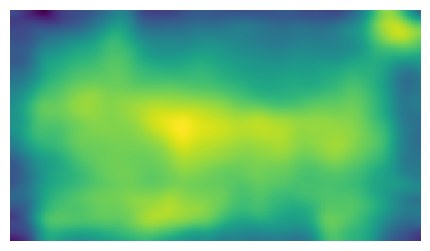

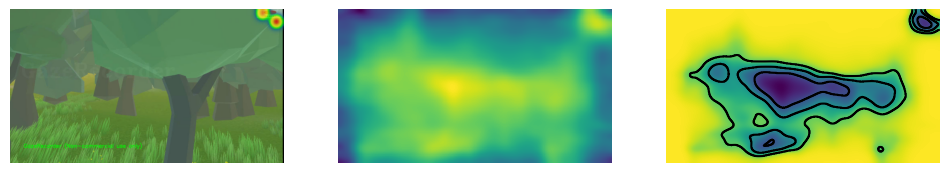

In [16]:
f1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axs1.matshow(log_density_prediction.detach().cpu().numpy()[0][0])
axs1.set_axis_off()
plt.savefig('C:/Users/dunea/Documents/Projet Julia/sal_map.png', bbox_inches='tight', pad_inches=0)

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axs[0].imshow(img)
axs[0].set_axis_off()
axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
axs[1].set_axis_off()
visualize_distribution(log_density_prediction.detach().cpu().numpy()[0, 0], ax=axs[2])
axs[2].set_axis_off()

#Save saliency map into file


Ci-dessous se trouve l'implémentation de la fonction permettant, pour un url d'image d'écran et 2 url sources pour les résultats, d'obtenir les calculs de saillance et ses niveaux pour l'image d'écran donnée, mais aussi d'enregistrer ces résultats dans les dossiers correspondants.

Dans un second temps, on pourra étudier l'efficacité de DeepGaze face au modèle actuellement employé sur les images non-photoréalistes de l'étude.

In [64]:
def compute_saliency(url, url2, url3, disp = False):
    
    img = Image.open(url).convert('RGB')
    #resize image
    basewidth = 1024
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    img = np.array(img)
    # rescale to match image size
    centerbias = zoom(centerbias_template, (img.shape[0]/centerbias_template.shape[0], img.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
    # renormalize log density
    centerbias -= logsumexp(centerbias)
    lis = np.array([img.transpose(2, 0, 1)])
    ctb = np.array([centerbias])
    image_tensor = torch.tensor(lis).to(DEVICE)
    centerbias_tensor = torch.tensor(ctb).to(DEVICE)
    log_density_prediction = model(image_tensor, centerbias_tensor)
    
    f1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
    axs1.matshow(log_density_prediction.detach().cpu().numpy()[0][0])
    axs1.set_axis_off()
    plt.savefig(url2, bbox_inches='tight', pad_inches=0)
    plt.clf()
    plt.close()

    f1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
    visualize_distribution(log_density_prediction.detach().cpu().numpy()[0, 0], ax=axs1)
    axs1.set_axis_off()
    plt.savefig(url3, bbox_inches='tight', pad_inches=0)
    plt.clf()
    plt.close()

    if disp == True:
        f, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
        axs[0].imshow(img)
        axs[0].set_axis_off()
        axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
        axs[1].set_axis_off()
        visualize_distribution(log_density_prediction.detach().cpu().numpy()[0, 0], ax=axs[2])
        axs[2].set_axis_off()
    
    #clear display
    
    return

compute_saliency("C:/Users/dunea/Documents/Projet Julia/screen.png", "C:/Users/dunea/Documents/Projet Julia/saliency_with_dg.png", "C:/Users/dunea/Documents/Projet Julia/saliency_heatmap_with_dg.png")

C:\Users\dunea\AppData\Local\Temp\ipykernel_15284\1062003453.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


Que remarque t'on ? Que tout comme dans le résultat du modèle précédent, on a effectivement un niveau de saillance élevé dans le coin supériieur droit, au niveau de l'emplacement du marqueur rouge 'rec'. Ci-dessous, on affiche en comparaison la réalité moyennée enregistrée avec le dispositif optique, la saillance calculée avec le modèle KSDG20, et la saillance calculée à l'aide de DeepGaze.

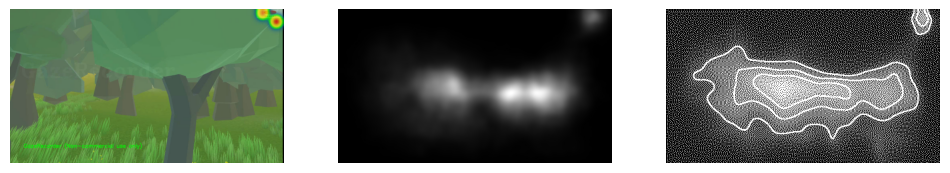

In [56]:
img = Image.open("C:/Users/dunea/Documents/Projet Julia/saliency.png").convert('RGB')
heatmap = Image.open("C:/Users/dunea/Documents/Projet Julia/heatmap.png").convert('RGB')
#Convert in black and white
sal = Image.open("C:/Users/dunea/Documents/Projet Julia/saliency_heatmap_with_dg.png")
#get the negative picture of the saliency map
sal = Image.fromarray(np.uint8(255 - np.array(sal)))

sal = sal.convert('L').convert('1')

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
axs[1].imshow(img)
axs[1].set_axis_off()
axs[2].imshow(sal)  # first image in batch, first (and only) channel
axs[2].set_axis_off()
axs[0].imshow(heatmap)
axs[0].set_axis_off()

In [65]:
for i in range(0, len(urls1)):
    compute_saliency(urls1[i][0], urls1[i][1], urls1[i][2])
for i in range(0, len(urls2)):
    compute_saliency(urls2[i][0], urls2[i][1], urls2[i][2])
for i in range(0, len(urls3)):
    compute_saliency(urls3[i][0], urls3[i][1], urls3[i][2])

C:\Users\dunea\AppData\Local\Temp\ipykernel_15284\1062003453.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
